In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnull
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml import Pipeline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Utilisation de la base de données Hive, et charge les données de la table

In [2]:
spark = SparkSession.builder \
    .appName("Categorie") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()


In [3]:
spark.sql("USE concessionnaire")
client_immat_df = spark.sql("SELECT * FROM client_immatriculation_categorie")

# Analyse des données.

### Afficher un aperçu des données

In [4]:
client_immat_df.show(3, truncate=False)

+---------------+---+-----+----+-------------------+---------------+---------------+----------+---------+--------+--------+--------+-------+--------+-------+------+---------+
|immatriculation|age|sexe |taux|situationfamilliale|nbenfantacharge|deuxiemevoiture|marque    |puissance|longueur|nbplaces|nbportes|couleur|occasion|prix   |modele|categorie|
+---------------+---+-----+----+-------------------+---------------+---------------+----------+---------+--------+--------+--------+-------+--------+-------+------+---------+
|0 NQ 98        |50 |Femme|243 |En Couple          |0              |true           |Volkswagen|55       |courte  |5       |3       |blanc  |true    |8540.0 |Polo  |citadine |
|0 PW 98        |58 |Homme|502 |Célibataire        |0              |false          |Peugeot   |75       |courte  |5       |5       |noir   |false   |13750.0|1007  |citadine |
|1 AK 80        |35 |Homme|1127|Célibataire        |0              |false          |Audi      |75       |courte  |5       |5 

In [5]:
client_immat_df.select("age","sexe","taux","situationfamilliale","nbenfantacharge","deuxiemevoiture","categorie").show(10, truncate=False)

+---+-----+----+-------------------+---------------+---------------+---------+
|age|sexe |taux|situationfamilliale|nbenfantacharge|deuxiemevoiture|categorie|
+---+-----+----+-------------------+---------------+---------------+---------+
|50 |Femme|243 |En Couple          |0              |true           |citadine |
|58 |Homme|502 |Célibataire        |0              |false          |citadine |
|35 |Homme|1127|Célibataire        |0              |false          |citadine |
|24 |Homme|1332|Célibataire        |0              |false          |citadine |
|68 |Homme|529 |En Couple          |2              |false          |familiale|
|53 |Homme|569 |En Couple          |3              |false          |sportive |
|32 |Homme|509 |En Couple          |0              |false          |familiale|
|32 |Homme|1184|Célibataire        |0              |false          |citadine |
|25 |Homme|1098|En Couple          |3              |false          |sportive |
|19 |Homme|203 |En Couple          |4              |

### Vérification des valeurs manquantes


In [6]:
missing_counts = client_immat_df.select([isnull(col(c)).alias(c) for c in client_immat_df.columns]).groupby().sum().show()

++
||
++
||
++



Notre DataFrame ne possède aucune valeur manquante.

#### Matrice de corrélation

Une matrice de corrélation est un outil statistique qui permet d’analyser les relations entre plusieurs variables numériques dans un ensemble de données.

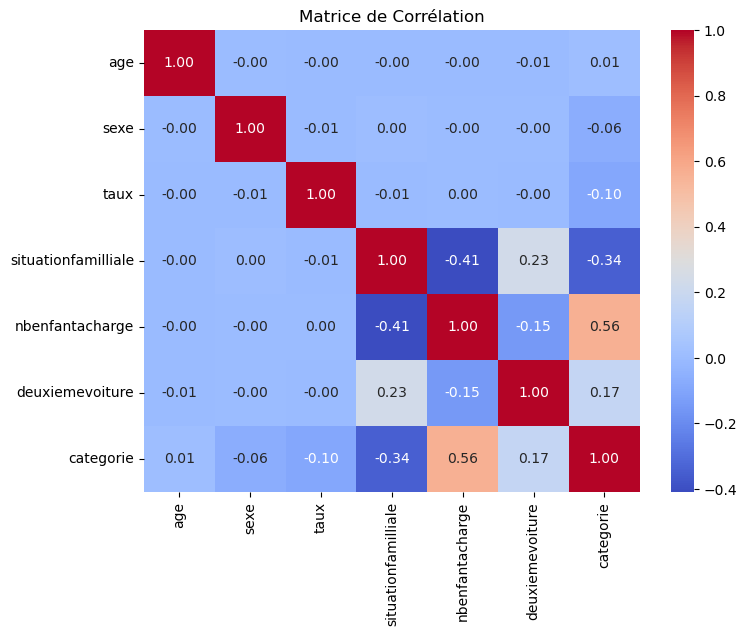

In [7]:
# Étape 1 : Conversion de PySpark DataFrame en Pandas DataFrame
df_pandas = client_immat_df.select("age", "sexe", "taux", "situationfamilliale", "nbenfantacharge", "deuxiemevoiture", "categorie").toPandas()

# Étape 2 : Encodage des colonnes catégoriques
# Convertir les colonnes catégoriques en numériques (avec pandas factorize ou pd.get_dummies)
for col in ["sexe", "situationfamilliale", "deuxiemevoiture", "categorie"]:
    df_pandas[col] = pd.factorize(df_pandas[col])[0]

# Étape 3 : Calcul de la matrice de corrélation
correlation_matrix = df_pandas.corr()

# Étape 4 : Visualisation avec Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=True, yticklabels=True)
plt.title("Matrice de Corrélation")
plt.show()

On peut voir une forte corrélation entre categorie et nbenfantacharge ette variable pourrait donc être cruciale pour prédire la catégorie., une corrélation négative entre situationfamilliale et categorie qui pourrait montrer que les personnes en couple preferer les voiture familialle et les personnes célibataire les citadine ou sportive 

### Analyse de la colonne age

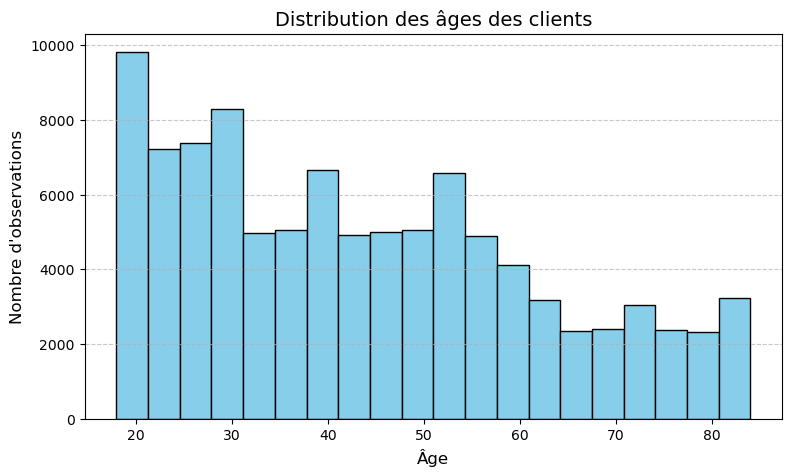

In [8]:
# Convertir les données PySpark en Pandas
df_pandas_age = client_immat_df.select("age").toPandas()

# Créer un histogramme pour visualiser la distribution des âges
plt.figure(figsize=(9, 5))
plt.hist(df_pandas_age["age"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution des âges des clients", fontsize=14)
plt.xlabel("Âge", fontsize=12)
plt.ylabel("Nombre d'observations", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### *Pic autour de 20-30 ans :*
Le graphique montre une concentration significative des clients dans la tranche d’âge des jeunes adultes (20-30 ans).
Cela pourrait indiquer que les jeunes adultes constituent une part importante des acheteurs ou des utilisateurs des services proposés.

#### *Répartition équilibrée entre 30 et 60 ans :*
La distribution des âges semble relativement uniforme dans la tranche 30-60 ans, avec des oscillations mineures.
Ces clients pourraient représenter une clientèle stable et régulière.

#### *Diminution après 60 ans :*
Une baisse du nombre de clients est observable après 60 ans.
Cela pourrait être lié à des facteurs comme une moindre mobilité ou des priorités différentes pour cette tranche d’âge.

#### *Présence d’une minorité au-delà de 70-80 ans :*
Bien qu’ils soient moins nombreux, les clients âgés de 70 ans et plus restent une part non négligeable. Des produits ou services adaptés à cette tranche pourraient être envisagés.

**Conclusion :**
Procédure possible pour cette colonne : normalisation ou catégorisation.

## Analyse sur la colonne nbenfantacharge

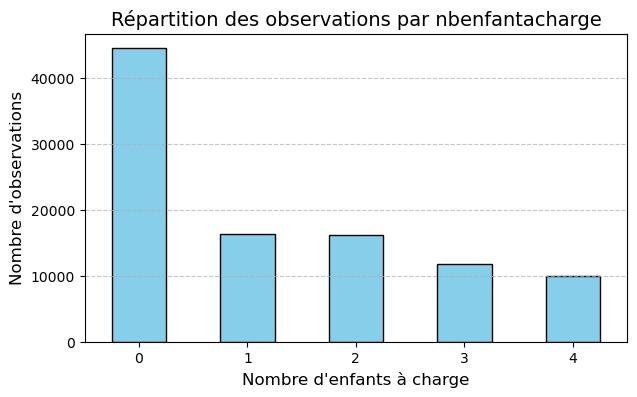

In [9]:
# Convertir les données PySpark en Pandas
df_pandas = client_immat_df.select("nbenfantacharge").toPandas()

# Compter le nombre d'observations pour chaque catégorie
count_data = df_pandas["nbenfantacharge"].value_counts().sort_index()

# Créer le graphique
plt.figure(figsize=(7, 4))
count_data.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Répartition des observations par nbenfantacharge", fontsize=14)
plt.xlabel("Nombre d'enfants à charge", fontsize=12)
plt.ylabel("Nombre d'observations", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

On vois sur le graphique precedent que la majorité des observations se trouvent dans la catégorie 0 (aucun enfant à charge).
Les autres valeurs (1, 2, 3, 4 enfants à charge) sont beaucoup moins fréquentes et relativement équilibrées entre elles.

On pourrait peux étre regrouper en deux ou trois categorie distinct.

Sois :
- 0 = Categorie 1
- 1,2,3,4 (Autre) = Categorie 2

Sois :
- 0 = Categorie 1
- 1,2 = Categorie 2
- Autre = Categorie 3

Cela permettrait d'être scalable dans le cas où un client aurait plus de 4 enfants.

## Analyse sur la colonne taux

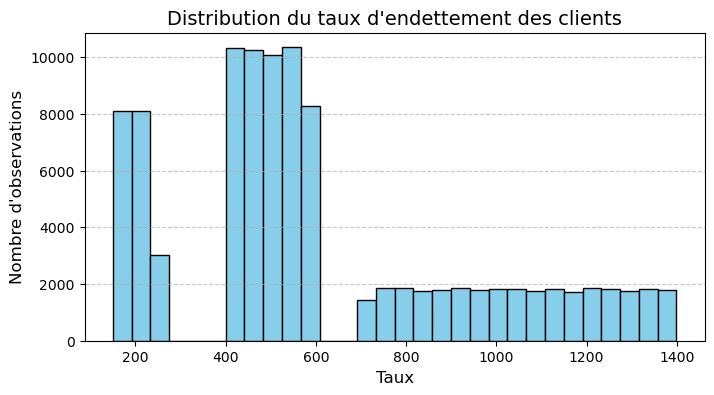

In [10]:
# Convertir la colonne "taux" en Pandas
df_pandas_taux = client_immat_df.select("taux").toPandas()

# Créer un histogramme pour visualiser la distribution de "taux"
plt.figure(figsize=(8, 4))
plt.hist(df_pandas_taux["taux"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution du taux d'endettement des clients", fontsize=14)
plt.xlabel("Taux", fontsize=12)
plt.ylabel("Nombre d'observations", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Machine Learning

## Étape 1 : Préparation des données

Je réduis le DataFrame de base avec toutes les colonnes pour récupérer les colonnes nécessaires à l'entraînement et utiles pour l'inférence.

In [11]:
# Sélection des colonnes nécessaires
df_reduit = client_immat_df.select("age", "sexe", "taux", "situationfamilliale", "nbenfantacharge", "deuxiemevoiture", "categorie")

### Normalisation de la colonne "age"

Après avoir tester les deux possibiliter entre la normalisation et la categorisation
J'ai garder la normalisation car le modèle et plus performant comme cela, et cela nous permet :
- Maintient la précision des données.
- D'exploiter des relations subtiles entre l'âge et d'autres variables.


In [12]:
# Étape 1 : Assembler l'âge dans un vecteur (nécessaire pour MinMaxScaler)
age_assembler = VectorAssembler(inputCols=["age"], outputCol="age_vector")

# Étape 2 : Appliquer le MinMaxScaler pour normaliser l'âge
age_scaler = MinMaxScaler(inputCol="age_vector", outputCol="age_scaled")

### Catégoriser l'âge (Non concluant)
df_reduit = df_reduit.withColumn(
    "age_categoriel",
    when((col("age") >= 0) & (col("age") < 10), "0-9 ans")
    .when((col("age") >= 10) & (col("age") < 20), "10-19 ans")
    .when((col("age") >= 20) & (col("age") < 30), "20-29 ans")
    .when((col("age") >= 30) & (col("age") < 40), "30-39 ans")
    .when((col("age") >= 40) & (col("age") < 50), "40-49 ans")
    .when((col("age") >= 50) & (col("age") < 60), "50-59 ans")
    .when((col("age") >= 60) & (col("age") < 70), "60-69 ans")
    .when((col("age") >= 70) & (col("age") < 80), "70-79 ans")
    .when((col("age") >= 80) & (col("age") < 90), "80-89 ans")
    .otherwise("90 ans et plus")
)


### Rendre catégorielle la colonne "nb_enfant_a_charge".

J'ai fait le choix de trois catégories car cela permet de conserver plus d'informations et de rendre le modèle légèrement plus précis et scalable.

### Transformer nbenfantacharge en catégories avec trois groupes (Non concluant)
df_reduit = df_reduit.withColumn(
    "nbenfantacharge_categoriel",
    when(df_reduit["nbenfantacharge"] == 0, "0")
    .when((df_reduit["nbenfantacharge"] >= 1) & (df_reduit["nbenfantacharge"] <= 2), "1")
    .otherwise("2")
)

Cette partie n'était pas concluante, le modèle perdait en précision.

### Normalisation de la colonne "taux"

In [13]:
# Assembler "taux" dans des vecteurs
taux_assembler = VectorAssembler(inputCols=["taux"], outputCol="taux_vector")

# Normaliser "taux" avec MinMaxScaler
taux_scaler = MinMaxScaler(inputCol="taux_vector", outputCol="taux_scaled")

J'ai essayé de catégoriser le taux, mais le résultat n'a pas été concluant.

## Étape 2 : Ajouter le StringIndexer
L'objectif principal est de convertir des colonnes catégoriques (texte) en colonnes numériques indexées à l'aide de la méthode StringIndexer. Cela est nécessaire pour rendre ces données compatibles avec des modèles qui n'acceptent que des valeurs numériques comme entrée.

In [14]:
# Encodage des colonnes catégoriques
indexers = [
    StringIndexer(inputCol="sexe", outputCol="sexe_index"),
    StringIndexer(inputCol="situationfamilliale", outputCol="situation_index"),
    StringIndexer(inputCol="deuxiemevoiture", outputCol="deuxiemevoiture_num"),
    StringIndexer(inputCol="categorie", outputCol="categorie_index"),
]

## Étape 3 : Construction et préparation des features

In [15]:
# Inclure la colonne normalisée dans les features
assembler = VectorAssembler(
    inputCols=["age_scaled", "sexe_index", "taux_scaled", "situation_index", "nbenfantacharge", "deuxiemevoiture_num"],
    outputCol="features"
)

# Construction du pipeline avec les étapes : encodage + normalisation + assemblage
pipeline = Pipeline(stages=indexers + [age_assembler, age_scaler, taux_assembler, taux_scaler, assembler])

# Transformation des données
df_final = pipeline.fit(df_reduit).transform(df_reduit)

# Afficher le schéma final
df_final.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sexe: string (nullable = true)
 |-- taux: integer (nullable = true)
 |-- situationfamilliale: string (nullable = true)
 |-- nbenfantacharge: integer (nullable = true)
 |-- deuxiemevoiture: string (nullable = true)
 |-- categorie: string (nullable = true)
 |-- sexe_index: double (nullable = false)
 |-- situation_index: double (nullable = false)
 |-- deuxiemevoiture_num: double (nullable = false)
 |-- categorie_index: double (nullable = false)
 |-- age_vector: vector (nullable = true)
 |-- age_scaled: vector (nullable = true)
 |-- taux_vector: vector (nullable = true)
 |-- taux_scaled: vector (nullable = true)
 |-- features: vector (nullable = true)



### Étape 4 : division des données
Entraînement et test.

In [16]:
# Division des données
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# Test modèle Random Forest

In [17]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Création du modèle Random Forest
rf = RandomForestClassifier(
    labelCol="categorie_index",  # La cible encodée
    featuresCol="features",  # Les vecteurs
    numTrees=20,  # Nombre d'arbres
    maxDepth=5,  # Profondeur maximale
    seed=42
)

In [18]:
# Entraînement
rf_model = rf.fit(train_data)

In [19]:
# Prédiction sur l'ensemble de test
predictions = rf_model.transform(test_data)

In [20]:
# Évaluation
evaluator = MulticlassClassificationEvaluator(
    labelCol="categorie_index", 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.7228330350294042


### Matrice de confusion
La matrice de confusion est un outil clé pour évaluer les performances d’un modèle de classification. Elle fournit une vue détaillée des prédictions correctes et incorrectes du modèle en comparant les classes prédites avec les classes réelles.

Affichage des indices et des labels pour les catégories.

In [21]:
categorie_indexer = StringIndexer(inputCol="categorie", outputCol="categorie_index")
fitted_categorie_indexer = categorie_indexer.fit(df_reduit)

print("Labels and Indices for 'categorie':")
for idx, label in enumerate(fitted_categorie_indexer.labels):
    print(f"  Index {idx}: {label}")

Labels and Indices for 'categorie':
  Index 0: familiale
  Index 1: sportive
  Index 2: citadine
  Index 3: autre
  Index 4: citadine premium


In [22]:
# Calcul de la matrice de confusion
confusion_matrix = predictions.groupBy("categorie_index", "prediction").count()

# Affichage de la matrice de confusion
confusion_matrix.orderBy("categorie_index", "prediction").show()

+---------------+----------+-----+
|categorie_index|prediction|count|
+---------------+----------+-----+
|            0.0|       0.0| 5882|
|            0.0|       2.0| 1433|
|            1.0|       0.0| 2454|
|            1.0|       1.0| 3543|
|            1.0|       3.0|    1|
|            2.0|       0.0|  565|
|            2.0|       2.0| 4706|
|            3.0|       0.0|  256|
|            3.0|       1.0|  412|
|            3.0|       2.0|  136|
|            3.0|       3.0|    4|
|            4.0|       0.0|   43|
|            4.0|       2.0|  120|
+---------------+----------+-----+



#### Analyse du resultat de la matrice de confusion

Classe 0.0 :

- Bien prédite (diagonale) : 5,882 exemples correctement classés.
- Mauvaises prédictions (classe 2.0) : 1,433 exemples confondus avec la classe 2.0.
- Cela montre que la classe 0.0 est bien gérée par le modèle, mais il y a des confusions importantes avec la classe 2.0.

Classe 1.0 :

- Bien prédite : 3,543 exemples.
- Confusion majeure avec la classe 0.0 : 2,454 exemples.
- Cela suggère que le modèle a du mal à séparer les classes 0.0 et 1.0.

Classe 2.0 :

- Bien prédite : 4,706 exemples.
- Confusions avec la classe 0.0 : 565 exemples.
- Cette classe est généralement bien prédite.

Classe 3.0 :

- Bien prédite : 4 exemples (faible).
- Confusions majeures :
    - Avec la classe 1.0 : 412 exemples.
    - Avec la classe 0.0 : 256 exemples.
- Le modèle a clairement du mal avec cette classe, ce qui peut être dû à un faible nombre d'exemples pour cette classe dans les données.

Classe 4.0 :

- Bien prédite : Pas d'exemple correctement classé (0 sur la diagonale).
- Confusion majeure avec la classe 2.0 : 120 exemples.
- Cela peut indiquer que cette classe n'est pas bien représentée ou qu'elle partage des caractéristiques similaires avec la classe 2.0.


#### Action possible
**Rééquilibrer les Données :**

Si certaines classes (comme 3.0 et 4.0) sont sous-représentées, on pourrait par exemple appliquer des techniques de sur-échantillonnage (SMOTE, duplication des données) ou de sous-échantillonnage des classes majoritaires.

**Analyser les Caractéristiques (Features) :**

On pourrait chercher si certaines caractéristiques contribuent aux confusions entre les classes. 
Pourquoi ne pas essayer d'ajouter des caractéristiques discriminantes pour séparer les classes proches ?

**Ajuster les Hyperparamètres :**

Augmentez le nombre d'arbres (numTrees) ou la profondeur maximale (maxDepth) pour améliorer la capture des relations complexes.

## Test sur marketing

In [23]:
# Charger les données depuis la table Hive
marketing_data = spark.sql("SELECT * FROM marketing_processed")

print(marketing_data.columns)

['deuxiemevoiture', 'age', 'nbenfantacharge', 'sexe', 'situationfamilliale', 'taux']


In [24]:
# Appliquer le pipeline
marketing_data_transformed = pipeline.fit(df_reduit).transform(marketing_data)

# Faire des prédictions
predictions = rf_model.transform(marketing_data_transformed)

# Afficher les prédictions
predictions.select("features", "prediction").show(10)


+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[0.25757575757575...|       2.0|
|[0.45454545454545...|       2.0|
|[0.12121212121212...|       1.0|
|[0.93939393939393...|       1.0|
|[0.13636363636363...|       0.0|
|[0.62121212121212...|       0.0|
|[0.37878787878787...|       0.0|
|[0.69696969696969...|       0.0|
|[0.06060606060606...|       0.0|
|[0.92424242424242...|       0.0|
+--------------------+----------+
only showing top 10 rows



In [25]:
indexer = StringIndexer(inputCol="categorie", outputCol="categorie_index")
model = indexer.fit(df_reduit)

print("Mappage des catégories :")
for i, label in enumerate(model.labels):
    print(f"{i}: {label}")

Mappage des catégories :
0: familiale
1: sportive
2: citadine
3: autre
4: citadine premium


# Fin de test Random Forest

# Test Logistic Regression :

In [26]:
from pyspark.ml.classification import LogisticRegression

# Création du modèle Logistic Regression
lr = LogisticRegression(
    labelCol="categorie_index",  # La cible encodée
    featuresCol="features",  # Les vecteurs de features
    maxIter=50,  # Nombre maximal d'itérations
    regParam=0.3,  # Paramètre de régularisation (L2)
    elasticNetParam=0.8  # Contrôle la régularisation (entre L1 et L2)
)

# Entraînement du modèle
lr_model = lr.fit(train_data)

# Prédictions sur les données de test
predictions_lr = lr_model.transform(test_data)

# Évaluation
evaluator_lr = MulticlassClassificationEvaluator(
    labelCol="categorie_index", 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy_lr = evaluator_lr.evaluate(predictions_lr)
print(f"Test Accuracy (Logistic Regression): {accuracy_lr}")


Test Accuracy (Logistic Regression): 0.46330861672206597


## Decision Tree Classifier

In [27]:
from pyspark.ml.classification import DecisionTreeClassifier

# Création du modèle Decision Tree Classifier
dt = DecisionTreeClassifier(
    labelCol="categorie_index",  # Colonne cible
    featuresCol="features",      # Colonne des features
    maxDepth=10,                 # Profondeur maximale de l'arbre
    maxBins=32                   # Nombre de bins pour les catégories continues
)

# Entraînement du modèle
dt_model = dt.fit(train_data)

# Prédictions sur les données de test
predictions_dt = dt_model.transform(test_data)

# Évaluation
evaluator_dt = MulticlassClassificationEvaluator(
    labelCol="categorie_index", 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy_dt = evaluator_dt.evaluate(predictions_dt)

print(f"Test Accuracy (Decision Tree): {accuracy_dt}")

Test Accuracy (Decision Tree): 0.7149066734850422
